# Getting tensorflow-serving working on eagle

First, built a tensorflow-serving docker container in /projects/rlmolecule/pstjohn/containers with
```bash
singularity build /projects/rlmolecule/pstjohn/containers/tensorflow-serving.simg docker://tensorflow/serving
singularity build /projects/rlmolecule/pstjohn/containers/tensorflow-serving-gpu.simg docker://tensorflow/serving:latest-gpu
```

*NOTE:* https://www.tensorflow.org/tfx/serving/docker#running_a_gpu_serving_image

In [1]:
# Be a good citizen when running this on a shared DAV node
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_memory_growth(gpus[0], True)
import nfp

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Load up the data we'll be fitting, in this case Yield Sooting Index (10.1016/j.combustflame.2017.12.005)
import pandas as pd
data = pd.read_csv('ysi.csv', index_col=0)
data.head()

,Species,YSI,SMILES,CAS,Formula,Ref,Type,YSI_err
0,2-~{tert}-butylfuran,107.5,CC(C)(C)c1ccco1,NaN,NaN,NaN,NaN,5.375
1,hex-2-yne,66.9,CC#CCCC,764-35-2,NaN,NaN,NaN,3.345
2,hept-2-yne,75.2,CC#CCCCC,1119-65-9,NaN,NaN,NaN,3.760
3,oct-2-yne,81.2,CC#CCCCCC,2809-67-8,NaN,NaN,NaN,4.060
4,"2,6,10-trimethyldodecane",109.8,CCC(C)CCCC(C)CCCC(C)C,3891-98-3,NaN,NaN,NaN,5.490


In [3]:
train = data.sample(frac=.8)
valid = data[~data.index.isin(train)]

Load NFP and construct the tensorflow inputs

In [4]:
import nfp
from tensorflow.keras import layers
from layers import NodeUpdate, EdgeUpdate, GlobalSumPooling1D

preprocessor = nfp.SmilesPreprocessor()

train_inputs = [preprocessor.construct_feature_matrices(smiles, train=True) for smiles in train.SMILES]
valid_inputs = [preprocessor.construct_feature_matrices(smiles, train=False) for smiles in valid.SMILES]

def create_dataset(inputs, targets):
    """ This process is still a bit of a pain. This does the padded batch operation
    for the above inputs to handle batching and variable-sized molecules """
    return tf.data.Dataset.from_generator(
        lambda: ((x, t) for x, t in zip(inputs, targets)),
        output_types=(preprocessor.output_types, tf.float32),
        output_shapes=(preprocessor.output_shapes, []))\
        .padded_batch(batch_size=16, 
                      padded_shapes=(preprocessor.padded_shapes(), []),
                      padding_values=(preprocessor.padding_values, 0.))\
        .prefetch(tf.data.experimental.AUTOTUNE)    


train_dataset = create_dataset(train_inputs, train.YSI).shuffle(500)
valid_dataset = create_dataset(valid_inputs, valid.YSI)

Specify and train a fairly simple GNN

In [5]:
atom_class = layers.Input(shape=[None], dtype=tf.int64, name='atom')
bond_class = layers.Input(shape=[None], dtype=tf.int64, name='bond')
connectivity = layers.Input(shape=[None, 2], dtype=tf.int64, name='connectivity')

# Initialize the atom states
atom_state = layers.Embedding(preprocessor.atom_classes, 16,
                              name='atom_embedding', mask_zero=True)(atom_class)

# This serves as a bias
atom_mean = layers.Embedding(preprocessor.atom_classes, 1,
                             name='atom_mean', mask_zero=True)(atom_class)

# Initialize the bond states
bond_state = layers.Embedding(preprocessor.bond_classes, 16,
                              name='bond_embedding', mask_zero=True)(bond_class)

for _ in range(3):
    bond_state = EdgeUpdate()([atom_state, bond_state, connectivity])
    atom_state = NodeUpdate()([atom_state, bond_state, connectivity])
    
out = layers.Dense(1)(atom_state)
out = layers.Add()([out, atom_mean])
out = GlobalSumPooling1D()(out)

# Todo: put in a model checkpoint callback

model = tf.keras.Model([atom_class, bond_class, connectivity], out)
model.compile(loss=tf.keras.losses.MeanSquaredLogarithmicError(), optimizer=tf.keras.optimizers.Adam(1E-3))
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
atom (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
bond (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
atom_embedding (Embedding)      (None, None, 16)     272         atom[0][0]                       
__________________________________________________________________________________________________
bond_embedding (Embedding)      (None, None, 16)     592         bond[0][0]                       
_______________________________________________________________________________________

In [9]:
model.fit(train_dataset, validation_data=valid_dataset, epochs=50, verbose=2)

Epoch 1/50


/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['n_atom', 'n_bond', 'bond_indices'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


29/29 - 1s - loss: 2.2238 - val_loss: 1.0542
Epoch 2/50
29/29 - 0s - loss: 0.8034 - val_loss: 0.4633
Epoch 3/50
29/29 - 1s - loss: 0.2688 - val_loss: 0.1564
Epoch 4/50
29/29 - 1s - loss: 0.1620 - val_loss: 0.1398
Epoch 5/50
29/29 - 0s - loss: 0.1468 - val_loss: 0.1377
Epoch 6/50
29/29 - 0s - loss: 0.1366 - val_loss: 0.1184
Epoch 7/50
29/29 - 0s - loss: 0.1287 - val_loss: 0.1183
Epoch 8/50
29/29 - 0s - loss: 0.1121 - val_loss: 0.1002
Epoch 9/50
29/29 - 0s - loss: 0.1030 - val_loss: 0.1075
Epoch 10/50
29/29 - 0s - loss: 0.0908 - val_loss: 0.0805
Epoch 11/50
29/29 - 0s - loss: 0.0871 - val_loss: 0.0839
Epoch 12/50
29/29 - 0s - loss: 0.0808 - val_loss: 0.0759
Epoch 13/50
29/29 - 0s - loss: 0.0784 - val_loss: 0.0759
Epoch 14/50
29/29 - 0s - loss: 0.0656 - val_loss: 0.0617
Epoch 15/50
29/29 - 0s - loss: 0.1429 - val_loss: 0.1046
Epoch 16/50
29/29 - 0s - loss: 0.1078 - val_loss: 0.1009
Epoch 17/50
29/29 - 0s - loss: 0.0999 - val_loss: 0.0773
Epoch 18/50
29/29 - 0s - loss: 0.0790 - val_loss: 0

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

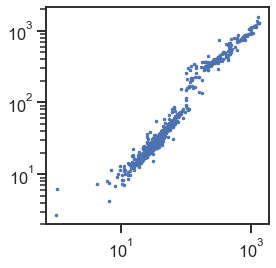

In [10]:
plt.figure(figsize=(4,4))
plt.loglog(valid.YSI, model.predict(valid_dataset), '.', ms=5)

In [11]:
# Following https://www.tensorflow.org/tfx/tutorials/serving/rest_simple

# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile
import os

MODEL_DIR = 'ysi_model'
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

export_path = ysi_model/1

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ysi_model/1/assets


### Running tensorflow serving

run_tf_serving.sh launches the tensorflow serving container with
```bash
SINGULARITYENV_MODEL_NAME=ysi_model singularity exec -B ./ysi_model:/models/ysi_model /projects/rlmolecule/pstjohn/containers/tensorflow-serving.simg tf_serving_entrypoint.sh
```

In [16]:
# Here's how we prepare the data on the worker nodes and serialize it to a json

import json
from json import JSONEncoder
import numpy as np

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

def trim_input(inputs, pad=True):
    """ The default SmilesPreprocessor returns some extra info we dont
    use in the simple model above, so we have to strip it down """
    data_dict = {key: val for key, val in inputs.items() 
                 if key in ['atom', 'bond', 'connectivity']}
    
    if pad:
        data_dict['atom'] = np.hstack([0, data_dict['atom']])
        data_dict['bond'] = np.hstack([0, data_dict['bond']])
        data_dict['connectivity'] = \
            np.vstack([np.array([0, 0]), data_dict['connectivity'] + 1])
        return data_dict        
 
    else:
        return data_dict

In [114]:
# We use requests to ping the TF serving model and get a response

import requests

test_input = trim_input(train_inputs[0], pad=False)
data = json.dumps({'instances': [test_input,]}, cls=NumpyArrayEncoder)
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/ysi_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

predictions

[[8.01673222]]

In [115]:
test_input = trim_input(train_inputs[0], pad=True)
data = json.dumps({'instances': [test_input,]}, cls=NumpyArrayEncoder)
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/ysi_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

predictions

[[8.01673317]]

In [116]:
train.iloc[0]

Species    Azetidine
YSI          6.10203
SMILES        C1CNC1
CAS         503-29-7
Formula        C3H7N
Ref              NaN
Type             NaN
YSI_err     0.305102
Name: 98, dtype: object

In [117]:
data = json.dumps({'instances': [trim_input(inputs, pad=True) for inputs in train_inputs[:2]]}, cls=NumpyArrayEncoder)
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/ysi_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)

predictions

{'error': "Failed to process element: 1 key: atom of 'instances' list. Error: Invalid argument: Expecting tensor size: 12 but got: 23"}

Great!, So, still todo:

2) Correctly configure the batching behavior on the TF serving side

3) Verify that calling and waiting for the GPU result is actually faster than just evaluating on the worker CPUs :). This would require a production-scale model though